<h2 style='color:blue' align='center'>Sports Celebrity Image Classification: Data Cleaning<h2>


Special thanks to Debjyoti Paul (My data scientist friend at Amazon) for help with this project


In [3]:
import numpy as np
import os
import cv2
import matplotlib
import pandas as pd
import seaborn as sn
import joblib
import json
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline

#### When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.</h4>


#### Now how do you detect face and eyes?


In [2]:
img = cv2.imread("./test_images/sharapova1.jpg")
img.shape

(555, 700, 3)

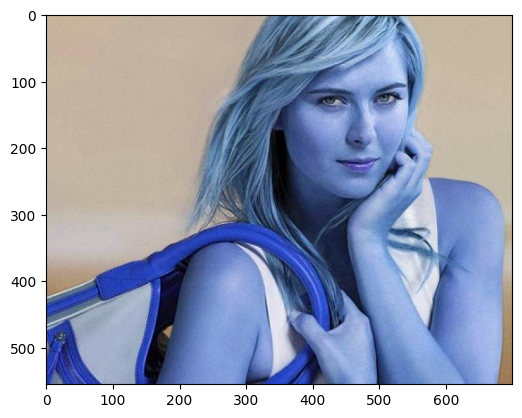

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(555, 700)

In [5]:
gray

array([[175, 175, 175, ..., 176, 175, 174],
       [175, 175, 175, ..., 177, 175, 174],
       [175, 175, 175, ..., 177, 176, 174],
       ...,
       [ 84,  87,  88, ..., 113, 113, 113],
       [ 88,  89,  90, ..., 113, 113, 113],
       [ 93,  91,  91, ..., 112, 112, 112]], dtype=uint8)

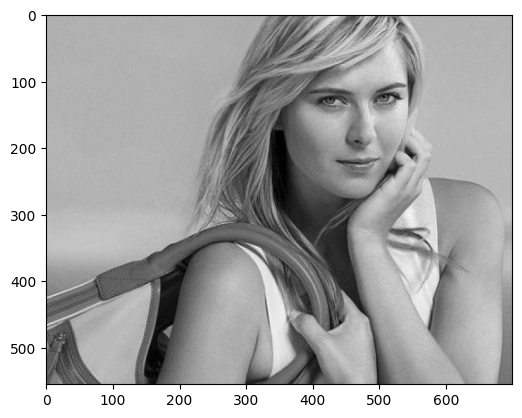

In [6]:
plt.imshow(gray, cmap="gray")

In [7]:
face_cascade = cv2.CascadeClassifier(
    "./opencv/haarcascades/haarcascade_frontalface_default.xml"
)
eye_cascade = cv2.CascadeClassifier("./opencv/haarcascades/haarcascade_eye.xml")

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[352,  38, 233, 233]], dtype=int32)

In [8]:
(x, y, w, h) = faces[0]
x, y, w, h

(np.int32(352), np.int32(38), np.int32(233), np.int32(233))

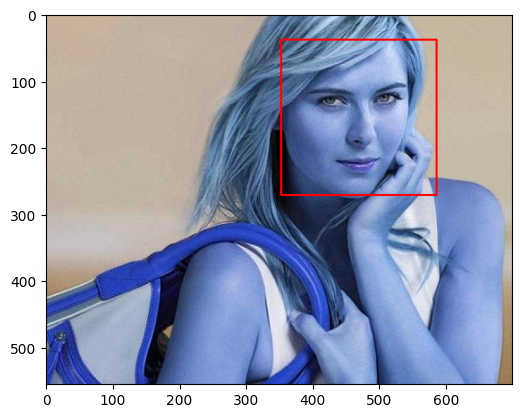

In [9]:
face_img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
plt.imshow(face_img)

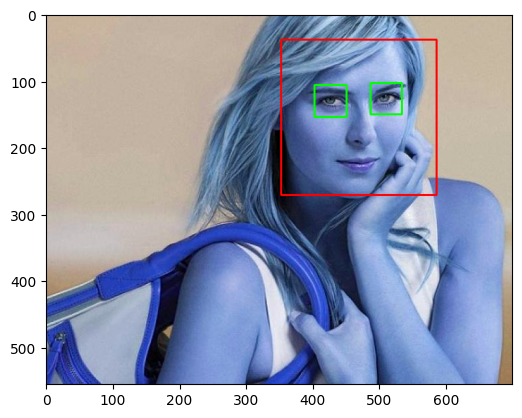

In [10]:
cv2.destroyAllWindows()
for x, y, w, h in faces:
    face_img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    roi_gray = gray[y : y + h, x : x + w]
    roi_color = face_img[y : y + h, x : x + w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for ex, ey, ew, eh in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)


plt.figure()
plt.imshow(face_img, cmap="gray")
plt.show()

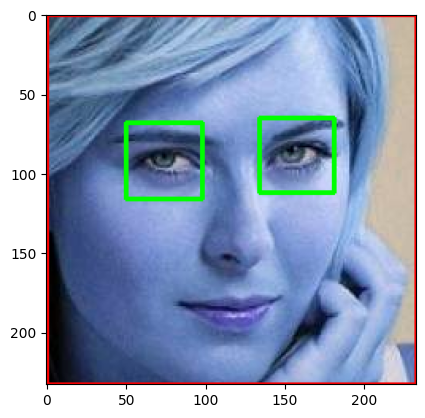

In [11]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [12]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for x, y, w, h in faces:
        roi_gray = gray[y : y + h, x : x + w]
        roi_color = img[y : y + h, x : x + w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

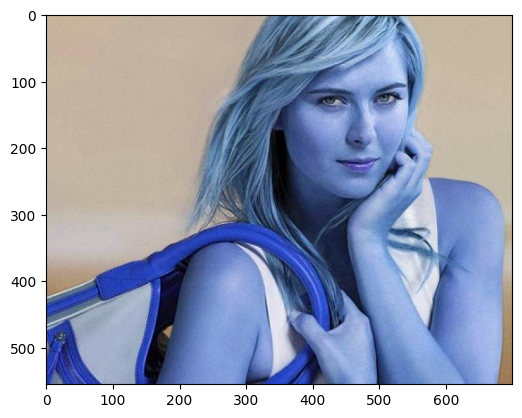

In [13]:
original_image = cv2.imread("./test_images/sharapova1.jpg")
plt.imshow(original_image)

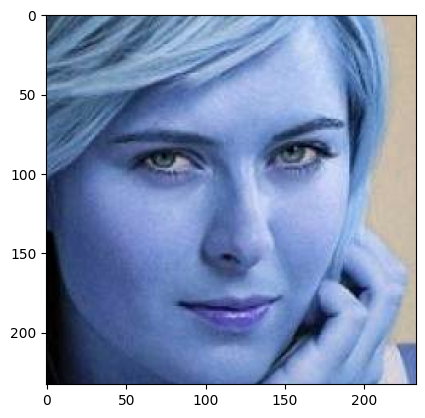

In [14]:
cropped_image = get_cropped_image_if_2_eyes("./test_images/sharapova1.jpg")
plt.imshow(cropped_image)

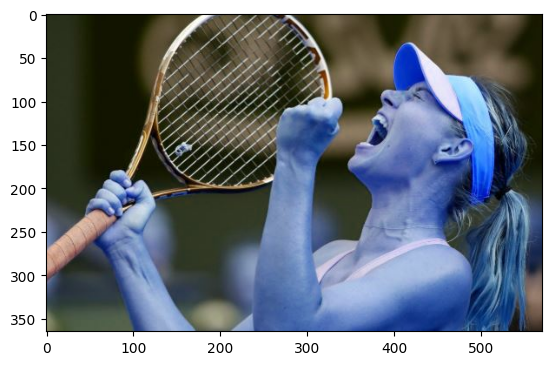

In [15]:
org_image_obstructed = cv2.imread("./test_images/sharapova2.jpg")
plt.imshow(org_image_obstructed)

In [16]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes("./test_images/sharapova2.jpg")
cropped_image_no_2_eyes

In [17]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [18]:
import os

img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [19]:
img_dirs

['./dataset/roger_federer',
 './dataset/lionel_messi',
 './dataset/virat_kohli',
 './dataset/maria_sharapova',
 './dataset/serena_williams']

In [20]:
# import shutil
# if os.path.exists(path_to_cr_data):
#      shutil.rmtree(path_to_cr_data)
# os.mkdir(path_to_cr_data)

In [21]:
# cropped_image_dirs = []
# celebrity_file_names_dict = {}

# for img_dir in img_dirs:
#     count = 1
#     celebrity_name = img_dir.split('/')[-1]
#     print(celebrity_name)

#     celebrity_file_names_dict[celebrity_name] = []

#     for entry in os.scandir(img_dir):
#         roi_color = get_cropped_image_if_2_eyes(entry.path)
#         if roi_color is not None:
#             cropped_folder = path_to_cr_data + celebrity_name
#             if not os.path.exists(cropped_folder):
#                 os.makedirs(cropped_folder)
#                 cropped_image_dirs.append(cropped_folder)
#                 print("Generating cropped images in folder: ",cropped_folder)

#             cropped_file_name = celebrity_name + str(count) + ".png"
#             cropped_file_path = cropped_folder + "/" + cropped_file_name

#             cv2.imwrite(cropped_file_path, roi_color)
#             celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
#             count += 1

roger_federer


Generating cropped images in folder:  ./dataset/cropped/roger_federer
lionel_messi
Generating cropped images in folder:  ./dataset/cropped/lionel_messi
virat_kohli
Generating cropped images in folder:  ./dataset/cropped/virat_kohli
maria_sharapova
Generating cropped images in folder:  ./dataset/cropped/maria_sharapova
serena_williams
Generating cropped images in folder:  ./dataset/cropped/serena_williams


In [4]:
cropped_image_dirs = [
    "./dataset/cropped/roger_federer",
    "./dataset/cropped/lionel_messi",
    "./dataset/cropped/virat_kohli",
    "./dataset/cropped/maria_sharapova",
    "./dataset/cropped/serena_williams",
]
celebrity_file_names_dict = {}
for i in cropped_image_dirs:
    celebrity_file_names_dict[i.split("/")[-1]] = list(
        map(lambda x: f"{i}/{x}", os.listdir(i))
    )

In [32]:
celebrity_file_names_dict

{'roger_federer': ['./dataset/cropped/roger_federer/roger_federer1.png',
  './dataset/cropped/roger_federer/roger_federer2.png',
  './dataset/cropped/roger_federer/roger_federer3.png',
  './dataset/cropped/roger_federer/roger_federer4.png',
  './dataset/cropped/roger_federer/roger_federer5.png',
  './dataset/cropped/roger_federer/roger_federer6.png',
  './dataset/cropped/roger_federer/roger_federer7.png',
  './dataset/cropped/roger_federer/roger_federer8.png',
  './dataset/cropped/roger_federer/roger_federer9.png',
  './dataset/cropped/roger_federer/roger_federer10.png',
  './dataset/cropped/roger_federer/roger_federer11.png',
  './dataset/cropped/roger_federer/roger_federer12.png',
  './dataset/cropped/roger_federer/roger_federer13.png',
  './dataset/cropped/roger_federer/roger_federer14.png',
  './dataset/cropped/roger_federer/roger_federer15.png',
  './dataset/cropped/roger_federer/roger_federer16.png',
  './dataset/cropped/roger_federer/roger_federer17.png',
  './dataset/cropped/ro

In [5]:
import pywt


def w2d(img, mode="haar", level=1):
    im_array = img
    im_array = cv2.cvtColor(im_array, cv2.COLOR_RGB2GRAY)
    im_array = np.float32(im_array)
    im_array /= 255
    coeffs = pywt.wavedec2(im_array, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    im_array_H = pywt.waverec2(coeffs_H, mode)
    im_array_H *= 255
    im_array_H = np.uint8(im_array_H)

    return im_array_H

In [6]:
im_har = w2d(cropped_image, "db1", level=5)
plt.imshow(im_har, cmap="gray")

NameError: name 'cropped_image' is not defined

In [7]:
class_dict = {}
for count, celebrity_name in enumerate(celebrity_file_names_dict, start=1):
    class_dict[celebrity_name] = count

class_dict

{'roger_federer': 1,
 'lionel_messi': 2,
 'virat_kohli': 3,
 'maria_sharapova': 4,
 'serena_williams': 5}

In [8]:
x = []
y = []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_img in training_files:
        img = cv2.imread(training_img)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, "db1", 5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack(
            (
                scalled_raw_img.reshape(32 * 32 * 3, 1),
                scalled_img_har.reshape(32 * 32, 1),
            )
        )
        x.append(combined_img)
        y.append(class_dict[celebrity_name])

In [9]:
len(x)

164

In [10]:
x = np.array(x).reshape(len(x), 4096).astype(float)
x.shape

(164, 4096)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [12]:
pipe = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="rbf", C=10))])
pipe.fit(x_train, y_train)
pipe.score(x_test, y_test)

0.8048780487804879

In [13]:
print(classification_report(y_test, pipe.predict(x_test)))

              precision    recall  f1-score   support

           1       0.89      0.89      0.89         9
           2       0.67      0.86      0.75         7
           3       0.82      1.00      0.90         9
           4       0.90      0.82      0.86        11
           5       0.50      0.20      0.29         5

    accuracy                           0.80        41
   macro avg       0.75      0.75      0.74        41
weighted avg       0.79      0.80      0.79        41



In [17]:
model_params = {
    "svm": {
        "model": SVC(probability=True),
        "params": {"svc__C": [1, 10, 100, 1000], "svc__kernel": ["rbf", "linear"]},
    },
    "random_forest": {
        "model": RandomForestClassifier(),
        "params": {"randomforestclassifier__n_estimators": [1, 5, 10]},
    },
    "logistic_regression": {
        "model": LogisticRegression(solver="liblinear", multi_class="auto"),
        "params": {"logisticregression__C": [1, 5, 10]},
    },
}

In [18]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp["model"])
    clf = GridSearchCV(pipe, mp["params"], cv=5, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append(
        {"model": algo, "best_score": clf.best_score_, "best_params": clf.best_params_}
    )
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores, columns=["model", "best_score", "best_params"])
df

/home/jaydh/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jaydh/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jaydh/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jaydh/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was 

,model,best_score,best_params
0,svm,0.836667,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.705667,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.852667,{'logisticregression__C': 1}


In [19]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=1, kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, multi_class='auto',
                                     solver='liblinear'))])}

In [20]:
best_estimators["svm"].score(x_test, y_test)

0.8292682926829268

In [21]:
best_estimators["random_forest"].score(x_test, y_test)

0.7073170731707317

In [22]:
best_estimators["logistic_regression"].score(x_test, y_test)

0.9024390243902439

In [23]:
best_clf = best_estimators["svm"]

In [24]:
cm = confusion_matrix(y_test, best_clf.predict(x_test))
cm

array([[8, 1, 0, 0, 0],
       [0, 6, 0, 0, 1],
       [0, 1, 8, 0, 0],
       [0, 1, 1, 9, 0],
       [0, 0, 0, 2, 3]])

Text(95.72222222222221, 0.5, 'Truth')

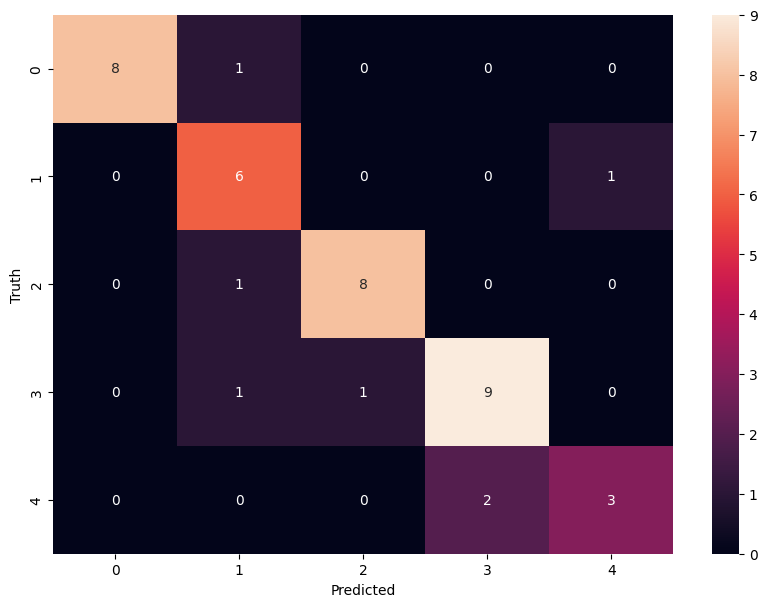

In [25]:
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [26]:
joblib.dump(best_clf, "saved_model.pkl")

['saved_model.pkl']

In [27]:
with open("class_dictionary.json", "w") as f:
    f.write(json.dumps(class_dict))